In [1]:
from __future__ import division

import warnings
from collections import namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.jit.annotations import Optional, Tuple
from torch import Tensor
import os

In [2]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
learningRate = 0.001
trainBatchSize = 100
testBatchSize = 100
epoches = 50
filename = "./output"

In [4]:
if not os.path.exists(filename):
    os.makedirs(filename)

In [5]:
import numpy as np
import os.path
from glob import glob
from PIL import Image
import torchvision.datasets as dset
import torch.utils.data as data
from ipywidgets import IntProgress
import torchvision.transforms as transforms
from matplotlib import pyplot as plt

In [6]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [7]:
#DATALOADER

train_set = dset.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=trainBatchSize, shuffle=True)
test_set = dset.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=testBatchSize, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size=1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_3_in, kernel_size=1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(True),

            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(True))


        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_5_in, kernel_size=1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(True),

            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),

            nn.Conv2d(kernel_5_x, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True))
         

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True))
       
    def forward(self, x):
        b1_output, b2_output, b3_output, b4_output  = self.b1(x), self.b2(x), self.b3(x) , self.b4(x)
        concat= torch.cat([b1_output,b2_output,b3_output,b4_output], 1)
        return concat

In [9]:
#CNN Model Defined Here

class GoogLeNet(nn.Module):

    def __init__(self):
        super(GoogLeNet, self).__init__()
        
        num_classses = 10
        input_channel = 3
        output_channel = 192
        
        self.initial = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, padding = 1, kernel_size = 3),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(True))
        
        self.inc1 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.inc2 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.MaxPool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inc3 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.inc4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.inc5 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.inc6 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.inc7 = Inception(528, 256, 160, 320, 32, 128, 128)
        
        self.MaxPool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.inc8 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inc9 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.AvgPool = nn.AvgPool2d(kernel_size=8, stride=1)

        self.fully_connected_layer  = nn.Linear(1024,10)

    def forward(self,x):
        x = self.initial(x)
        x = self.inc1(x)
        x = self.inc2(x)
        x = self.MaxPool1(x)
        x = self.inc3(x)
        x = self.inc4(x)
        x = self.inc5(x)
        x = self.inc6(x)
        x = self.inc7(x)
        x = self.MaxPool2(x)
        x = self.inc8(x)
        x = self.inc9(x)
        x = self.AvgPool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fully_connected_layer(x)

        return x

In [10]:
#CNN MODEL CREATED HERE

goNetwork = GoogLeNet()
goNetwork.to(device)

GoogLeNet(
  (initial): Sequential(
    (0): Conv2d(3, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (inc1): Inception(
    (b1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (b2): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (b3): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, mo

In [11]:
optimizer = torch.optim.Adam(goNetwork.parameters(), lr=learningRate)

cross_entropy = torch.nn.CrossEntropyLoss(weight = None, size_average=None)

milestones = [50,100]

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.5, last_epoch=-1, verbose=False)

In [12]:
#TRAINING AND LOSS CALCULATION DEFINED HERE

def training(train_set, train_loader, device, optimizer, test_loader):
    goNetwork.train()
    
    train_loss = 0
    total_data = 0
    prediction = 0
    data_size1 = 0
    num_corr_predictions1 =0
    total_datasize1 = 0
    
    for (data, value) in train_loader:
        corr_pred1 = 0
        
        data = data.to(device)
        value = value.to(device)
        
        optimizer.zero_grad()
        
        forwarded_data = goNetwork(data)
        loss = cross_entropy(forwarded_data, value)
    
        loss.backward()
        optimizer.step()
        
        train_loss = train_loss + loss.data.item()
        
        max_elements, max_idxs = torch.max(forwarded_data, dim = 1)
        prediction = max_idxs
        
        data_size1 = value.size(0)
        total_datasize1 = total_datasize1 + data_size1
        
        for i in range(data_size1):
            if prediction[i] == value[i]:
                corr_pred1+=1
        
        num_corr_predictions1 += corr_pred1
    
    goNetwork.eval()
    test_loss = 0
    total_data = 0
    num_corr_predictions = 0
    
    data_size = 0
    total_datasize = 0
    pred_test = 0
    
    with torch.no_grad():
        for (data,value) in test_loader:
            corr_pred = 0
            
            data = data.to(device)
            value = value.to(device)
            
            forwarded_data = goNetwork(data)
            
            loss = cross_entropy(forwarded_data, value)
            test_loss = test_loss + loss.data.item()
            
            max_elements, max_idxs = torch.max(forwarded_data, dim = 1)
            prediction = max_idxs
            
            data_size = value.size(0)
            total_datasize = total_datasize + data_size
            
            for i in range(data_size):
                if prediction[i]==value[i]:
                    corr_pred+=1
            
            num_corr_predictions += corr_pred
        
    training_acc = num_corr_predictions1 / total_datasize1
    testing_acc = num_corr_predictions / total_datasize
    
    return training_acc, testing_acc, train_loss, test_loss

In [13]:
print(torch.cuda.memory_summary(device=None, abbreviated = False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   24244 KB |   24244 KB |   24244 KB |       0 B  |
|       from large pool |   10050 KB |   10050 KB |   10050 KB |       0 B  |
|       from small pool |   14194 KB |   14194 KB |   14194 KB |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |   24244 KB |   24244 KB |   24244 KB |       0 B  |
|       from large pool |   10050 KB |   10050 KB |   10050 KB |

In [14]:
best_test = 0
best_epoch = -1

epochs_count = []
LossTrain, LossTest = [], []

#Actual training
for i in range(epoches):
    print("Epoch: ", i)
    epochs_count.append(i)
    
    scheduler.step()
    training_acc, testing_acc, train_loss, test_loss = training(train_set, train_loader, device, optimizer, test_loader)
    
    training_acc = training_acc * 100
    testing_acc = testing_acc * 100
    
    if testing_acc > best_test:
        best_epoch = i
        best_test = testing_acc
    
    LossTrain.append(train_loss)
    LossTest.append(test_loss)
    
    print("Trainig accuracy is: ", ("%.4g" % training_acc), "%, Testing accuracy: ", ("%.4g" % testing_acc), "%.")
    print("Training loss is: ", train_loss, " Testing loss is: ", test_loss)
    
torch.save(goNetwork, "model")
print("_____________________________________________________________________________")
print("Best Epoch was: ", best_epoch, " at ", best_test, "% accuracy")
print("_____________________________________________________________________________")

Epoch:  0


/usr/lib/python3/dist-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Trainig accuracy is:  55.4 %, Testing accuracy:  62.52 %.
Training loss is:  613.8194760084152  Testing loss is:  104.10876077413559
Epoch:  1
Trainig accuracy is:  73.13 %, Testing accuracy:  75.35 %.
Training loss is:  381.2637403309345  Testing loss is:  69.80498299002647
Epoch:  2
Trainig accuracy is:  79.49 %, Testing accuracy:  77.33 %.
Training loss is:  295.55380645394325  Testing loss is:  66.80865967273712
Epoch:  3
Trainig accuracy is:  83.07 %, Testing accuracy:  80.8 %.
Training loss is:  242.5434563755989  Testing loss is:  54.69844502210617
Epoch:  4
Trainig accuracy is:  85.74 %, Testing accuracy:  83.06 %.
Training loss is:  206.81958982348442  Testing loss is:  50.57338112592697
Epoch:  5
Trainig accuracy is:  87.58 %, Testing accuracy:  83.88 %.
Training loss is:  180.8682935833931  Testing loss is:  48.220229759812355
Epoch:  6
Trainig accuracy is:  89.02 %, Testing accuracy:  86.17 %.
Training loss is:  158.82082455605268  Testing loss is:  40.49205628037453
Epoch:

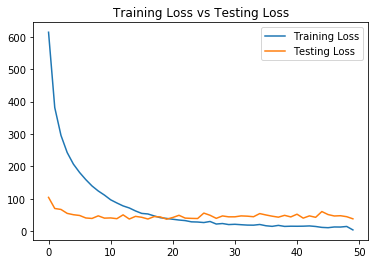

In [15]:
#PLOTTING LOSS CONVERGENCE

import matplotlib.pyplot as plt

plt.title('Training Loss vs Testing Loss')
plt.plot(epochs_count,LossTrain, label='Training Loss')
plt.plot(epochs_count,LossTest, label='Testing Loss')
plt.legend()
plt.show()